In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import glob
import tqdm as tqdm
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn import model_selection
from sklearn.model_selection import KFold
import xgboost as xgb

In [46]:
# For quickly switching between training and test data
def train_test(mode):
    # mode = "train"/"test"
    file_name = '../input/optiver-realized-volatility-prediction/' + mode + '.csv'
    return pd.read_csv(file_name)

def my_metrics(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def rmspe(y_true, y_pred):  
    output = my_metrics(y_true, y_pred)
    return 'rmspe', output, False

def is_in(stock_groups, stock_id):
    for i in range(len(stock_groups)):
        if stock_id in stock_groups[i]:
            return i
    
# custom aggregate function
def wap2vol(df):
    # wap2vol stands for WAP to Realized Volatility
    temp = np.log(df).diff() # calculating tik to tik returns
    # returning realized volatility
    return np.sqrt(np.sum(temp**2)) 

def rv(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def agg(df_book, stock_stat, feature, func, new_name = None, rename = False):
    if rename:
        stock_stat = pd.merge( df_book.groupby(by = ['time_id'])[feature].agg(func).reset_index().rename(columns = {feature : new_name}),
        stock_stat, on = ['time_id'], how = 'left')    
    else:
        stock_stat = pd.merge( df_book.groupby(by = ['time_id'])[feature].agg(func).reset_index(),
            stock_stat, on = ['time_id'], how = 'left')     
    return stock_stat

# for inference，应用模型
def linear_inference(models, stock_id, stock_groups, volatility_features, degree, grouped = True):
    if grouped:
        model = models[is_in(stock_groups, stock_id)]
    else:
        model = models[stock_id]
    polyfeat = PolynomialFeatures(degree = degree)
    return model.predict(polyfeat.fit_transform([volatility_features]))[0]

In [47]:
train = train_test("train")
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [48]:
test = train_test("test")
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [49]:
# trade data statics
trade_training = glob.glob('../input/optiver-realized-volatility-prediction/trade_train.parquet/*')
path = trade_training[0]
stock_id = int(path.split('=')[1])

In [50]:
# 计算trade的统计特征
def trade_stock_stat(path, stock_id):
    trade =  pd.read_parquet(path)
    trade['stock_id'] = stock_id
    trade['trade_log_return'] = trade.groupby(['time_id'])['price'].apply(log_return).fillna(0)
    trade_features = ["price", "size", "order_count", "trade_log_return"]
    # print("Trade", trade)
    for feature in trade_features:
        if feature == "price":
            stock_stat = agg(trade, trade, feature, func = "mean", rename = True, new_name = feature + "_mean")
        else:
            stock_stat = agg(trade, stock_stat, feature, func = "mean", rename = True, new_name = feature + "_mean")
        stock_stat = agg(trade, stock_stat, feature, func = max, rename = True, new_name = feature + "_max")
        stock_stat = agg(trade, stock_stat, feature, func = min, rename = True, new_name = feature + "_min")
        stock_stat = agg(trade, stock_stat, feature, func = sum, rename = True, new_name = feature + "_sum")
#         print(stock_stat)
        if feature == "trade_log_return":
            stock_stat = agg(trade, stock_stat, feature, func = rv, rename = True, new_name = feature + "_rv")
   #     print("End df", stock_stat)
   # print("Final df", stock_stat)    
    return stock_stat

In [51]:
def get_trade_overall(book):
    total_df = pd.DataFrame()
    for i in tqdm.tqdm(book):
        temp_stock = int(i.split("=")[1])
        temp_relvol = trade_stock_stat(path = i, stock_id = temp_stock)
#         print(temp_relvol)
#         print(temp_relvol.columns)
        total_df = pd.concat([total_df, temp_relvol])
    return total_df

In [52]:
# orderbook:构建ordrbook特征
def get_stock_stat(path, stock_id):
    df_book = pd.read_parquet(path)
    # wap1
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1'])/(df_book['bid_size1']+ df_book['ask_size1'])
    # wap2
    a = df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']
    b = df_book['bid_size2']+ df_book['ask_size2']
    df_book['wap2'] = a/b
    # wap3
    a1 = df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']
    a2 = df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']
    b = df_book['bid_size1'] + df_book['ask_size1'] + df_book['bid_size2']+ df_book['ask_size2']    
    df_book['wap3'] = (a1 + a2)/ b
    # wap4 
    a = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) / (
                                       df_book['bid_size1']+ df_book['ask_size1'])
    b = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) / (
                                       df_book['bid_size2']+ df_book['ask_size2'])
    df_book['wap4'] = (a + b) / 2
    # log_return
    df_book['vol_wap1'] = (df_book.groupby(by = ['time_id'])['wap1'].apply(log_return).reset_index(drop = True).fillna(0))
    df_book['vol_wap2'] = (df_book.groupby(by = ['time_id'])['wap2'].apply(log_return).reset_index(drop = True).fillna(0))
    df_book['vol_wap3'] = (df_book.groupby(by = ['time_id'])['wap3'].apply(log_return).reset_index(drop = True).fillna(0))
    df_book['vol_wap4'] = (df_book.groupby(by = ['time_id'])['wap4'].apply(log_return).reset_index(drop = True).fillna(0))
    # bas
    df_book['bas'] = (df_book[['ask_price1', 'ask_price2']].min(axis = 1)
                                / df_book[['bid_price1', 'bid_price2']].max(axis = 1) - 1)
    # different spreads
    df_book['h_spread_l1'] = df_book['ask_price1'] - df_book['bid_price1']
    df_book['h_spread_l2'] = df_book['ask_price2'] - df_book['bid_price2']
    df_book['v_spread_b'] = df_book['bid_price1'] - df_book['bid_price2']
    df_book['v_spread_a'] = df_book['ask_price1'] - df_book['ask_price2']
    df_book['spread_dif1'] = df_book['ask_price1'] - df_book['bid_price2']
    df_book['spread_dif2'] = df_book['ask_price2'] - df_book['bid_price1']

    # attach volatitilies based on different VWAPs
    stock_stat = pd.merge(
        df_book.groupby(by = ['time_id'])['vol_wap1'].agg(rv).reset_index(),
        df_book.groupby(by = ['time_id'], as_index = False)['bas'].mean(),
        on = ['time_id'], how = 'left'
    )
    
    vol_features = ["vol_wap2", "vol_wap3", "vol_wap4"]
    spread_features = ["h_spread_l1", 'h_spread_l2', 'v_spread_b', 'v_spread_a', "spread_dif1", "spread_dif2"]
    time_features = ["seconds_in_bucket"]

    for feature in vol_features:
         stock_stat = agg(df_book, stock_stat, feature, rv)

    for feature in spread_features:
        stock_stat = agg(df_book, stock_stat, feature, func = max, rename = True, new_name = feature + "_max")
        stock_stat = agg(df_book, stock_stat, feature, func = min, rename = True, new_name = feature + "_min")
        stock_stat = agg(df_book, stock_stat, feature, func = sum, rename = True, new_name = feature + "_sum")
        stock_stat = agg(df_book, stock_stat, feature, func = "mean", rename = True, new_name = feature + "_mean")

    for feature in time_features:
        stock_stat = agg(df_book, stock_stat, feature, func = max, rename = True, new_name = feature + "_max")
        stock_stat = agg(df_book, stock_stat, feature, func = min, rename = True, new_name = feature + "_min")
        stock_stat = agg(df_book, stock_stat, feature, func = sum, rename = True, new_name = feature + "_sum")
        stock_stat = agg(df_book, stock_stat, feature, func = "mean", rename = True, new_name = feature + "_mean")
    
    stock_stat['stock_id'] = stock_id

    return stock_stat

In [53]:
# 遍历orderbook
def get_overall(book):
    total_df = pd.DataFrame()
    for i in tqdm.tqdm(book):
        temp_stock = int(i.split("=")[1])
        temp_relvol = get_stock_stat(i, temp_stock)
    #    print(temp_relvol)
        total_df = pd.concat([total_df, temp_relvol])
    return total_df


In [54]:
def linear_training(X,y,degree):
    # instantiating polynomial features
    polyfeat = PolynomialFeatures(degree = degree)
    weights = 1/np.square(y)
   # linreg = linear_model.LinearRegression()
    linreg = XGBRegressor(eval_metric = rmspe, sample_weight = weights)
    # preprocessing the training data
    x = np.array(X)
    x = np.array(X).reshape(-1,len(x[0]))
    # x = np.array(X).reshape(-1,1)
    # creating the polynomial features
    X_ = polyfeat.fit_transform(x)
    # training the model

    return clf.fit(X_, np.array(y).reshape(-1,1), sample_weight = weights)

# 这个转换让人懵逼
def transform(X, polyfeat):
    x = np.array(X)
    x = np.array(X).reshape(-1,len(x[0]))
    X = polyfeat.fit_transform(x)
    return X

In [55]:
# 重头戏来了，xgboost
def Xgboost(X,y,degree=1,params={'reg_alpha':20,'reg_lambda':20,'max_depth':5,'n_estimators':500},folds=10):
    polyfeat = PolynomialFeatures(degree = degree)
    skf = KFold(n_splits=folds, shuffle=True, random_state=42)
    for fold, (tr_idx, ts_idx) in enumerate(skf.split(X)):
        x_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        x_ts, y_ts = X.iloc[ts_idx], y.iloc[ts_idx]
        x_tr = transform(x_tr, polyfeat)
        x_ts = transform(x_ts, polyfeat)
        weights = np.array(1/np.square(y_tr))
        eval_weights = np.array(1/np.square(y_ts))
        model = XGBRegressor(**params)
        model.fit(x_tr, y_tr,
                 eval_set=[(x_ts, y_ts)],
                 early_stopping_rounds=10, sample_weight = weights, sample_weight_eval_set = [eval_weights],
                  verbose=False) 
    return model

In [56]:
#辅助函数，把list L分成 n 组
def chunks(L, n): return [L[x: x+n] for x in range(0, len(L), n)]

#计算训练分数
def train_score(joined, models, stock_groups, feature_list, degree = 1):
    train_pred = create_submission(joined, joined, models, stock_groups, feature_list, degree = degree, merge = True)
    rmspe_train = rmspe(np.array(train_pred["target_x"]), np.array(train_pred["target_y"]))
    return rmspe_train

# 创建submission
def create_submission(test_df, joined, models, stock_groups, feature_list, degree = 1, merge = False):
    submission = pd.DataFrame({"row_id" : [], "target" : []})  
    submission["row_id"] = test_df.apply(lambda x: str(int(x.stock_id)) + '-' + str(int(x.time_id)), axis=1)
    submission["target"] = test_df.apply(lambda x: linear_inference(models, x.stock_id, stock_groups, list(x[feature_list]), degree),axis = 1)
    if merge:
        submission["stock_id"] = test_df.apply(lambda x: int(x.stock_id), axis = 1)
        submission["time_id"] = test_df.apply(lambda x: int(x.time_id), axis=1)
        overall = joined.merge(submission, on = ["stock_id", "time_id"], how = "left")
        return overall
    else:
        return submission

In [57]:
# 获取各类模型，对应的是那只股票
def get_model(train, joined, feature_list, group_number = 5, group = True, degree = 1, xgboost = False):
    stock_groups = chunks(list(joined.groupby("stock_id").mean()["target"].reset_index().sort_values(by = "target")["stock_id"]), group_number)
    stock_id_train = train.stock_id.unique() # all stock_id for the train set
    models = {} # dictionary for holding trained models for each stock_id
    if not group:
        for i in tqdm.tqdm(stock_id_train):
            temp = joined[joined["stock_id"]==i]
            X = temp[feature_list]
            y = temp["target"]
            if xgboost:
                models[i] = Xgboost(X, y, degree = degree, folds=5)
           #     xgb.plot_importance(models[i], title = "Feature importance for stock id {}:".format(i))
            else:
                models[i] = linear_training(X,y,degree)
    else:
        for i in tqdm.tqdm(range(len(stock_groups))):
            temp = joined[joined["stock_id"].isin(stock_groups[i])]
            X = temp[feature_list]
            y = temp["target"]
            if xgboost:
                models[i] = Xgboost(X, y, degree = degree, folds=5)
         #       xgb.plot_importance(models[i], title = "Feature importance for stock ids {}:".format("".join(str(stock_groups[i]))))
            else:
                models[i] = linear_training(X,y,degree)
    return models


In [58]:
# 组合orderbook数据和trade数据,生成特征
def merge_frames(train = True):
    if train:
        order_book_training = glob.glob('../input/optiver-realized-volatility-prediction/book_train.parquet/*')
        total_df = get_overall(order_book_training)
        trade_training = glob.glob('../input/optiver-realized-volatility-prediction/trade_train.parquet/*')
        total_trade = get_trade_overall(trade_training).drop(columns = ["seconds_in_bucket", "price", "size", "order_count", "trade_log_return"]).drop_duplicates()
        total_df = total_df.merge(total_trade, on = ["stock_id","time_id"], how = "left")
    else:
        # listing all test order books
        order_book_test = glob.glob('../input/optiver-realized-volatility-prediction/book_test.parquet/*')
        test_df = get_overall(order_book_test)
        trade_test = glob.glob('../input/optiver-realized-volatility-prediction/trade_test.parquet/*')
        total_test = get_trade_overall(trade_test).drop(columns = ["seconds_in_bucket", "price", "size", "order_count", "trade_log_return"]).drop_duplicates()
        total_df = test_df.merge(total_test, on = ["stock_id","time_id"], how = "left")
    return total_df

In [64]:
# 测试集所有数据
pd.set_option('display.max_columns',None)
test_df = merge_frames(train = False)
test_df


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


,time_id,seconds_in_bucket_mean,seconds_in_bucket_sum,seconds_in_bucket_min,seconds_in_bucket_max,spread_dif2_mean,spread_dif2_sum,spread_dif2_min,spread_dif2_max,spread_dif1_mean,spread_dif1_sum,spread_dif1_min,spread_dif1_max,v_spread_a_mean,v_spread_a_sum,v_spread_a_min,v_spread_a_max,v_spread_b_mean,v_spread_b_sum,v_spread_b_min,v_spread_b_max,h_spread_l2_mean,h_spread_l2_sum,h_spread_l2_min,h_spread_l2_max,h_spread_l1_mean,h_spread_l1_sum,h_spread_l1_min,h_spread_l1_max,vol_wap4,vol_wap3,vol_wap2,vol_wap1,bas,stock_id,trade_log_return_rv,trade_log_return_sum,trade_log_return_min,trade_log_return_max,trade_log_return_mean,order_count_sum,order_count_min,order_count_max,order_count_mean,size_sum,size_min,size_max,size_mean,price_sum,price_min,price_max,price_mean
0,4,2,6,0,5,0.000672,0.002016,0.00059,0.000836,0.000951,0.002852,0.000934,0.000983,-0.000115,-0.000344,-0.000246,-0.000049,0.000393,0.00118,0.000393,0.000393,0.001065,0.003196,0.000983,0.001229,0.000557,0.001672,0.000541,0.00059,0.000273,0.000263,0.000252,0.000294,0.000557,0,0.000295,-0.000285,-0.000295,0.00001,-0.000095,11,1,7,3.666667,201,1,100,67,3.000452,1.000049,1.000344,1.000151


In [65]:
# 合并test测试集和train训练集,输出特征列表
def combined(train, save = True, read = False):
    total_df = merge_frames()
    if read:
        joined = pd.read_csv("../input/weighted-regression-with-stock-grouping-and-eda/Joined1.csv")
    else:    
        joined = train.merge(total_df, on = ["stock_id","time_id"], how = "left")
    
    if save:
        joined.to_csv("Joined1.csv", index = False)

    feature_list = list(joined.drop(columns = ["stock_id", "time_id", "target"]).columns)
    return feature_list, joined

In [66]:
feature_list, joined = combined(train, save = True)
feature_list


100%|██████████| 112/112 [20:43<00:00, 11.10s/it]

100%|██████████| 112/112 [38:10<00:00, 20.45s/it]


['seconds_in_bucket_mean',
 'seconds_in_bucket_sum',
 'seconds_in_bucket_min',
 'seconds_in_bucket_max',
 'spread_dif2_mean',
 'spread_dif2_sum',
 'spread_dif2_min',
 'spread_dif2_max',
 'spread_dif1_mean',
 'spread_dif1_sum',
 'spread_dif1_min',
 'spread_dif1_max',
 'v_spread_a_mean',
 'v_spread_a_sum',
 'v_spread_a_min',
 'v_spread_a_max',
 'v_spread_b_mean',
 'v_spread_b_sum',
 'v_spread_b_min',
 'v_spread_b_max',
 'h_spread_l2_mean',
 'h_spread_l2_sum',
 'h_spread_l2_min',
 'h_spread_l2_max',
 'h_spread_l1_mean',
 'h_spread_l1_sum',
 'h_spread_l1_min',
 'h_spread_l1_max',
 'vol_wap4',
 'vol_wap3',
 'vol_wap2',
 'vol_wap1',
 'bas',
 'trade_log_return_rv',
 'trade_log_return_sum',
 'trade_log_return_min',
 'trade_log_return_max',
 'trade_log_return_mean',
 'order_count_sum',
 'order_count_min',
 'order_count_max',
 'order_count_mean',
 'size_sum',
 'size_min',
 'size_max',
 'size_mean',
 'price_sum',
 'price_min',
 'price_max',
 'price_mean']

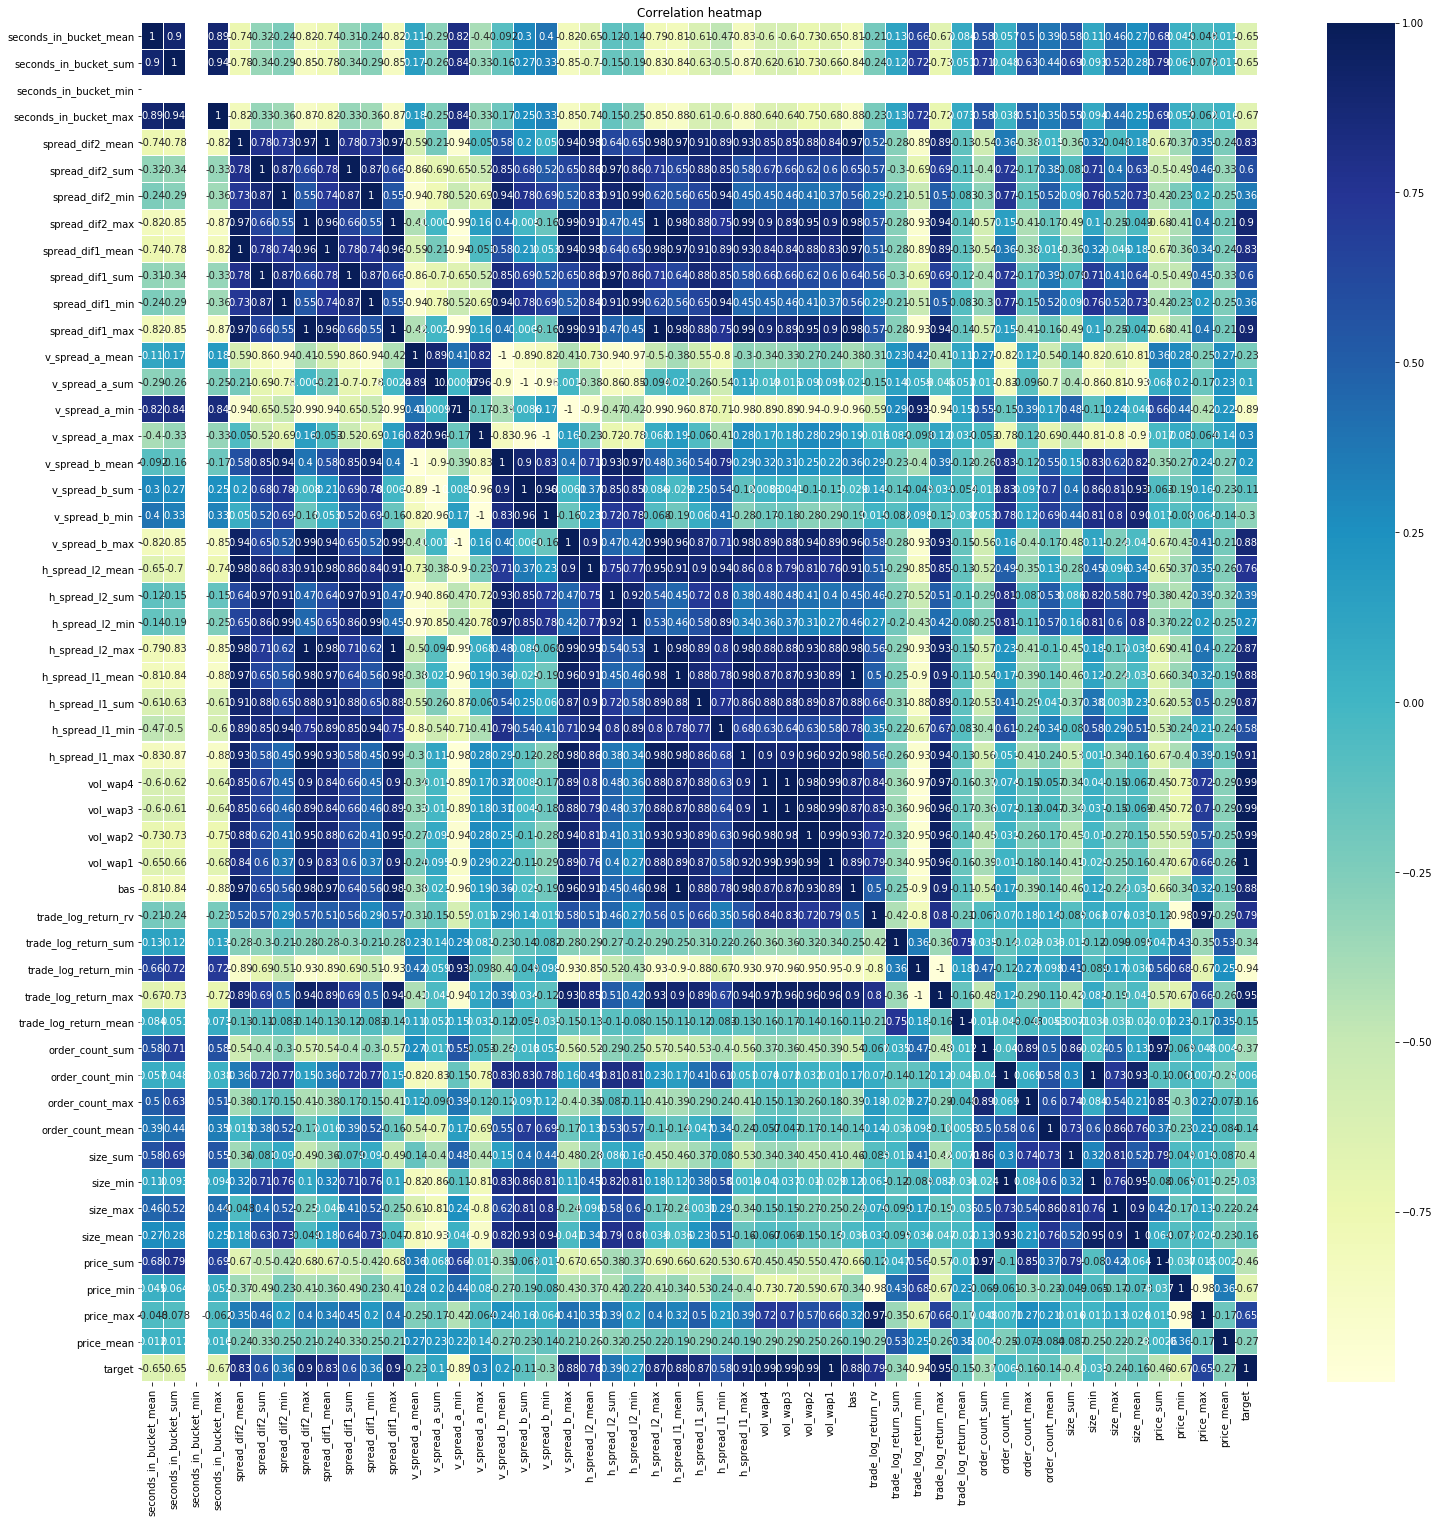

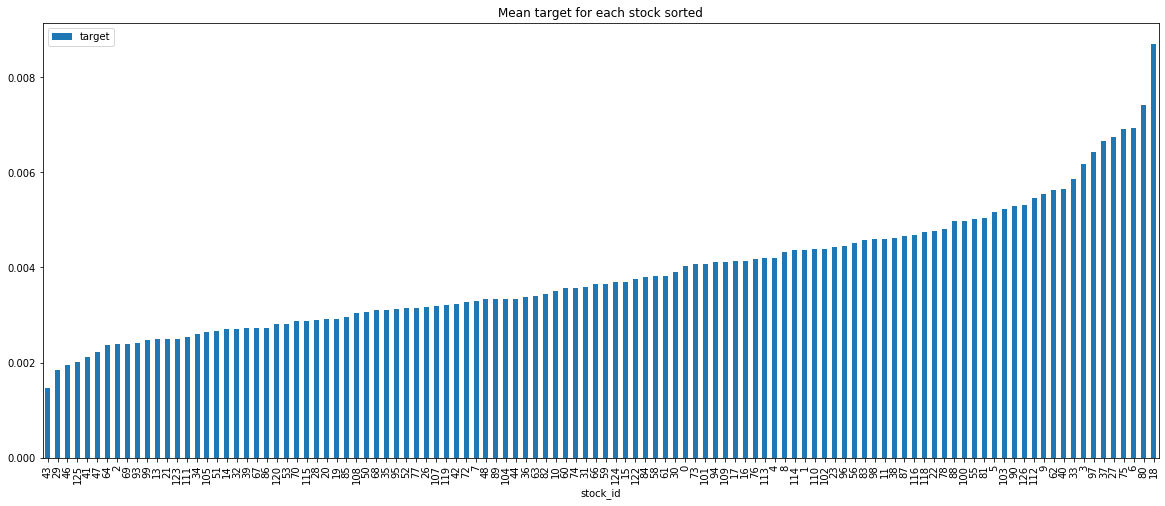

In [67]:
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(joined.groupby(by = "stock_id").mean()[feature_list + ["target"]].corr(), center = 0, annot = True, cmap="YlGnBu", linewidths = .05)
plt.title("Correlation heatmap")
joined.groupby("stock_id").mean()["target"].reset_index().sort_values(by = "target").plot(x = "stock_id", y = "target", kind = "bar", figsize = (20, 8), title = "Mean target for each stock sorted")

In [68]:
joined[joined["order_count_max"].isnull()]

,stock_id,time_id,target,seconds_in_bucket_mean,seconds_in_bucket_sum,seconds_in_bucket_min,seconds_in_bucket_max,spread_dif2_mean,spread_dif2_sum,spread_dif2_min,spread_dif2_max,spread_dif1_mean,spread_dif1_sum,spread_dif1_min,spread_dif1_max,v_spread_a_mean,v_spread_a_sum,v_spread_a_min,v_spread_a_max,v_spread_b_mean,v_spread_b_sum,v_spread_b_min,v_spread_b_max,h_spread_l2_mean,h_spread_l2_sum,h_spread_l2_min,h_spread_l2_max,h_spread_l1_mean,h_spread_l1_sum,h_spread_l1_min,h_spread_l1_max,vol_wap4,vol_wap3,vol_wap2,vol_wap1,bas,trade_log_return_rv,trade_log_return_sum,trade_log_return_min,trade_log_return_max,trade_log_return_mean,order_count_sum,order_count_min,order_count_max,order_count_mean,size_sum,size_min,size_max,size_mean,price_sum,price_min,price_max,price_mean
66123,18,8524,0.002151,318.166667,22908.0,0,568,0.002270,0.163469,0.002065,0.003011,0.002464,0.177422,0.002020,0.003172,-0.000051,-0.003708,-0.000051,-0.000051,0.000245,0.017660,0.000006,0.000946,0.002516,0.181129,0.002072,0.003223,0.002219,0.159761,0.002014,0.002959,0.005014,0.006489,0.009035,0.005954,0.002221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107340,31,985,0.004124,319.349673,97721.0,0,597,0.003208,0.981551,0.003208,0.003208,0.003208,0.981551,0.003208,0.003208,-0.001604,-0.490776,-0.001604,-0.001604,0.001604,0.490776,0.001604,0.001604,0.004812,1.472327,0.004812,0.004812,0.001604,0.490776,0.001604,0.001604,0.000347,0.000281,0.000059,0.000693,0.001605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107715,31,3987,0.001488,280.015306,54883.0,0,599,0.003060,0.599850,0.003060,0.003060,0.003060,0.599838,0.003060,0.003060,-0.001530,-0.299937,-0.001530,-0.001530,0.001530,0.299925,0.001530,0.001530,0.004591,0.899775,0.004591,0.004591,0.001530,0.299913,0.001530,0.001530,0.000314,0.000092,0.000012,0.000626,0.001531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107915,31,5539,0.002650,294.226966,130931.0,0,599,0.002093,0.931446,0.002093,0.002093,0.002093,0.931472,0.002093,0.002093,-0.001047,-0.465710,-0.001047,-0.001047,0.001047,0.465736,0.001047,0.001047,0.003140,1.397182,0.003140,0.003140,0.001047,0.465736,0.001047,0.001047,0.000225,0.000219,0.000152,0.000420,0.001047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107922,31,5629,0.002491,312.021654,158507.0,0,599,0.001716,0.871737,0.001716,0.001716,0.001716,0.871707,0.001716,0.001716,-0.000858,-0.435899,-0.000858,-0.000858,0.000858,0.435869,0.000858,0.000858,0.002574,1.307606,0.002574,0.002574,0.000858,0.435838,0.000858,0.000858,0.000495,0.000682,0.000201,0.000950,0.000858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107999,31,6197,0.001931,287.602094,109864.0,0,598,0.002827,1.079864,0.002827,0.002827,0.002827,1.079841,0.002827,0.002827,-0.001413,-0.539943,-0.001413,-0.001413,0.001413,0.539921,0.001413,0.001413,0.004240,1.619785,0.004240,0.004240,0.001413,0.539921,0.001413,0.001413,0.000304,0.000253,0.000034,0.000607,0.001414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108289,31,8753,0.000612,290.601156,100548.0,0,599,0.002905,1.005093,0.002905,0.002905,0.002905,1.005093,0.002905,0.002905,-0.001452,-0.502546,-0.001452,-0.001452,0.001452,0.502546,0.001452,0.001452,0.004357,1.507639,0.004357,0.004357,0.001452,0.502546,0.001452,0.001452,0.000296,0.000275,0.000129,0.000580,0.001454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108297,31,8840,0.003263,284.170000,56834.0,0,589,0.003276,0.655210,0.003276,0.003276,0.003276,0.655198,0.003276,0.003276,-0.001638,-0.327611,-0.001638,-0.001638,0.001638,0.327599,0.001638,0.001638,0.004914,0.982809,0.004914,0.004914,0.001638,0.327599,0.001638,0.001638,0.000114,0.000131,0.000122,0.000194,0.001639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108339,31,9208,0.000246,307.420912,114668.0,0,599,0.003303,1.232038,0.003303,0.003303,0.003303,1.232038,0.003303,0.003303,-0.001652,-0.616019,-0.001652,-0.001

In [73]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428932 entries, 0 to 428931
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   stock_id                428932 non-null  int64  
 1   time_id                 428932 non-null  int64  
 2   target                  428932 non-null  float64
 3   seconds_in_bucket_mean  428932 non-null  float64
 4   seconds_in_bucket_sum   428932 non-null  float64
 5   seconds_in_bucket_min   428932 non-null  int16  
 6   seconds_in_bucket_max   428932 non-null  int16  
 7   spread_dif2_mean        428932 non-null  float32
 8   spread_dif2_sum         428932 non-null  float32
 9   spread_dif2_min         428932 non-null  float32
 10  spread_dif2_max         428932 non-null  float32
 11  spread_dif1_mean        428932 non-null  float32
 12  spread_dif1_sum         428932 non-null  float32
 13  spread_dif1_min         428932 non-null  float32
 14  spread_dif1_max     

In [88]:
# 对nan的特征进行填充，特征数据处理
def fill_nan(joined):
    nan_features = list(joined.columns)[32:]
    missing_stock_ids = list(joined[joined["trade_log_return_rv"].isnull()]["stock_id"].unique())
    for stock_id in missing_stock_ids:
        for feature in nan_features:
            # 均值填充
            if joined.loc[joined["stock_id"] == stock_id, feature].isnull().all():
                joined.loc[joined["stock_id"] == stock_id, feature] = joined.loc[joined["stock_id"] == stock_id, feature].fillna(joined[feature].mean())
            else:
                joined.loc[joined["stock_id"] == stock_id, feature] = joined.loc[joined["stock_id"] == stock_id, feature].fillna(joined.loc[joined["stock_id"] == stock_id, feature].mean())
    return joined
joined = fill_nan(joined)
print("Missing count after filling", joined.isnull().any().sum())


Missing count after filling 0


In [96]:
group_numbers = [1]
degrees = [1]
scores = {}
validate = True
for group_number in group_numbers:
    for degree in degrees:
        stock_groups = chunks(list(joined.groupby("stock_id").mean()["target"].reset_index().sort_values(by = "target")["stock_id"]), group_number)
        models = get_model(train, joined, feature_list, group_number = group_number, group = True, degree = degree, xgboost = True)
        if validate:
            overall_train_score = train_score(joined, models, stock_groups, feature_list, degree = degree)
            print("Train score for group number {} and degree {}:".format(group_number, degree), overall_train_score)
            scores[str(group_number) + " - " + str(degree)] = overall_train_score


100%|██████████| 112/112 [03:08<00:00,  1.68s/it]
Train score for group number 1 and degree 1: ('rmspe', 0.18772154051607995, False)


In [101]:
submission = create_submission(test_df, joined, models, stock_groups, feature_list, degree = 1, merge = False)
submission.to_csv("submission.csv", index = False)
submission


,row_id,target
0,0-4,0.004076
